In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')


In [71]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
IDtest = test["PassengerId"]

In [72]:
# Outlier detection : Tukey method (Tukey JW., 1977)
def detect_outliers(df,n,features):
    
    outlier_indices = []
    for col in features:
        # 1st quartile(25%)
        Q1 = np.percentile(df[col],25)
        # 3rd quartile(75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range(IQR) 25%~75%
        IQR = Q3-Q1
        
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers
        outlier_list_col = df[(df[col] < Q1-outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # Append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
    
    # select observed values containing more than n outliers
    outlier_indices = Counter(outlier_indices)
    print(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v>n )
    
    return multiple_outliers

In [73]:
# detect outliers on numerical values
Outliers_to_drop = detect_outliers(train,2,['Age','SibSp','Parch','Fare']) 
print("===========")
print(Outliers_to_drop)

Counter({27: 3, 88: 3, 159: 3, 180: 3, 201: 3, 324: 3, 341: 3, 792: 3, 846: 3, 863: 3, 7: 2, 16: 2, 24: 2, 50: 2, 59: 2, 63: 2, 68: 2, 71: 2, 119: 2, 164: 2, 171: 2, 176: 2, 182: 2, 229: 2, 233: 2, 261: 2, 266: 2, 278: 2, 374: 2, 386: 2, 409: 2, 480: 2, 485: 2, 541: 2, 542: 2, 634: 2, 642: 2, 683: 2, 686: 2, 787: 2, 813: 2, 819: 2, 824: 2, 850: 2, 102: 2, 118: 2, 124: 2, 262: 2, 268: 2, 297: 2, 299: 2, 305: 2, 311: 2, 318: 2, 319: 2, 332: 2, 377: 2, 390: 2, 435: 2, 438: 2, 445: 2, 498: 2, 540: 2, 550: 2, 558: 2, 581: 2, 585: 2, 587: 2, 659: 2, 679: 2, 689: 2, 698: 2, 742: 2, 745: 2, 763: 2, 779: 2, 802: 2, 820: 2, 835: 2, 856: 2, 879: 2, 85: 1, 726: 1, 8: 1, 10: 1, 13: 1, 25: 1, 43: 1, 54: 1, 58: 1, 65: 1, 78: 1, 86: 1, 93: 1, 97: 1, 98: 1, 128: 1, 136: 1, 140: 1, 145: 1, 147: 1, 148: 1, 153: 1, 155: 1, 160: 1, 165: 1, 166: 1, 167: 1, 172: 1, 175: 1, 183: 1, 184: 1, 188: 1, 193: 1, 197: 1, 205: 1, 237: 1, 247: 1, 248: 1, 251: 1, 254: 1, 255: 1, 259: 1, 272: 1, 273: 1, 279: 1, 312: 1, 3

In [74]:
train.loc[Outliers_to_drop] # outlier rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [75]:
# drop outliers
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

In [76]:
# Join train & test datasets to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [77]:
# fill empty & NaNs vlaues with NaN
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [78]:
train.info()
train.isnull().sum()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [79]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


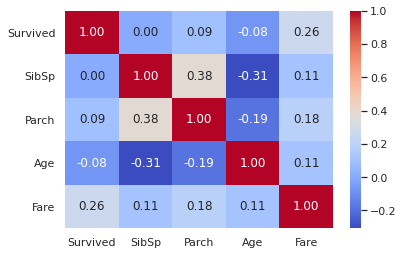

In [80]:
# Numerical values
# Correlation matrix
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

Only Fare feature seems to have a significative correlation with the survival probability.

It doesn't mean that the other features are not usefull. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features



/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


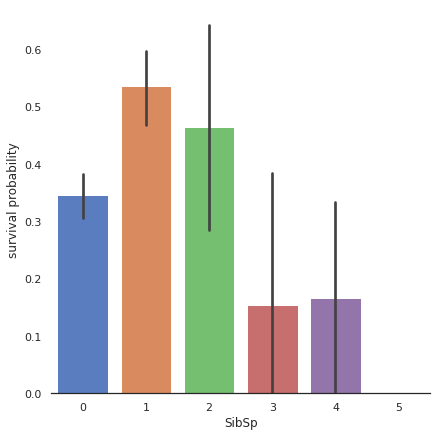

In [81]:
# SibSP
g = sns.factorplot(x="SibSp", y="Survived", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passengers having a lot of siblings/spouses have less chance to survive

Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive

This observation is quite interesting, we can consider a new feature describing these categories (See feature engineering)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


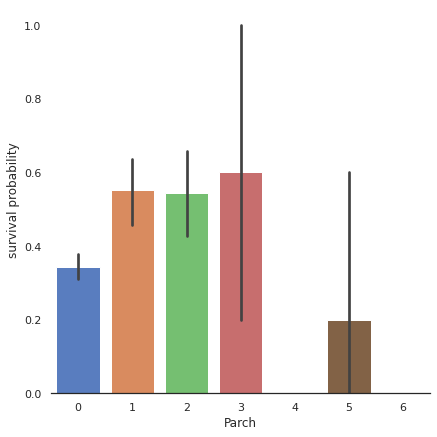

In [82]:
# parch
g = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar",size=6,palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6 ).

Be carefull there is an important standard deviation in the survival of passengers with 3 parents/children

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


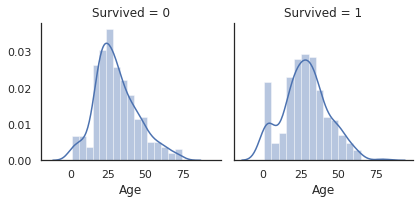

In [83]:
# Age
g = sns.FacetGrid(train, col="Survived")
g = g.map(sns.distplot, "Age")
#g = g.map(sns.distplot, "Parch")

Age distribution seems to be a tailed distribution, maybe a gaussian distribution.

We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived.

So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.

It seems that very young passengers have more chance to survive.

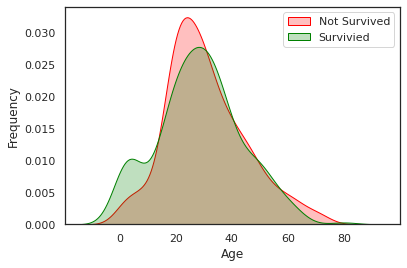

In [84]:
g = sns.kdeplot( train["Age"][(train["Survived"]==0) & (train["Age"].notnull())], color="Red", shade = True )
g = sns.kdeplot( train["Age"][(train["Survived"]==1) & (train["Age"].notnull())], ax=g, color="Green", shade = True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survivied"])
# When we superimpose the two densities , we cleary see a peak correponsing (between 0 and 5) to babies and very young childrens.

In [85]:
# Fare
print(dataset["Fare"].isnull().sum())
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

1


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


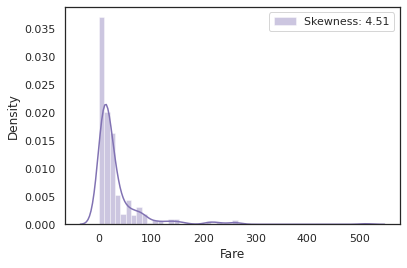

In [86]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness: %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

# As we can see, Fare distribution is very skewed. 
# This can lead to overweigth very high values in the model, even if it is scaled.
# In this case, it is better to transform it with the log function to reduce this skew.
# 너무 편향된 데이터는 편향된 부분만 훈련되는 경우가 생길 수 있으므로 regularization 작업이 필요

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


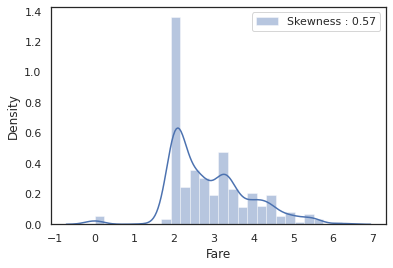

In [87]:
# Apply log
dataset["Fare"] = dataset["Fare"].map(lambda i:np.log(i) if i>0 else 0)

g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()) )
g = g.legend(loc="best")

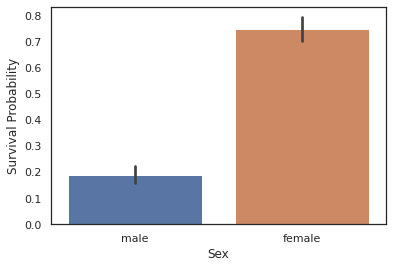

In [88]:
# Categorical Values
# Sex
g = sns.barplot(x="Sex", y="Survived", data=train)
g = g.set_ylabel("Survival Probability")

In [89]:
train[["Sex","Fare","Survived"]].groupby("Sex").mean()

,Fare,Survived
Sex,,
female,42.822048,0.747573
male,24.800851,0.190559


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


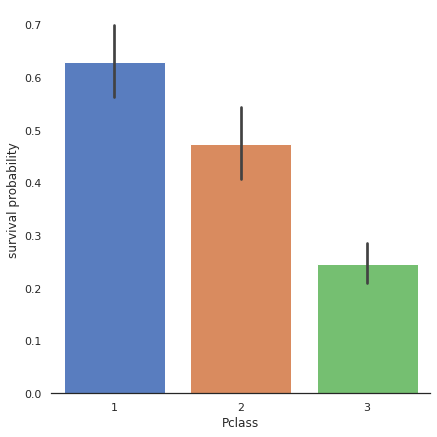

In [90]:
# Pclass
g = sns.factorplot(x="Pclass", y="Survived", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


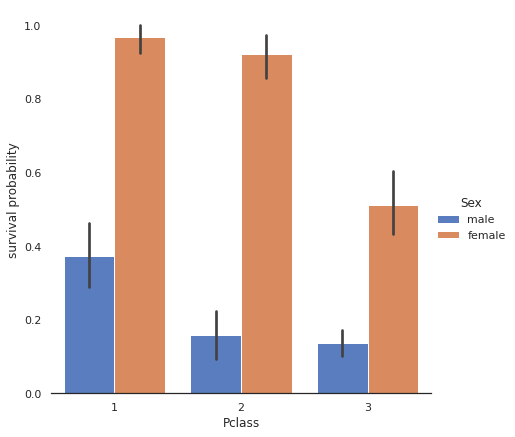

In [91]:
# Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train, size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [92]:
# Embarked
dataset["Embarked"].isnull().sum()

2

In [93]:
# Fill nan on Embarked with 'S' that is most frequent value
print(dataset["Embarked"].value_counts())
dataset["Embarked"] = dataset["Embarked"].fillna("S")

S    904
C    270
Q    123
Name: Embarked, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


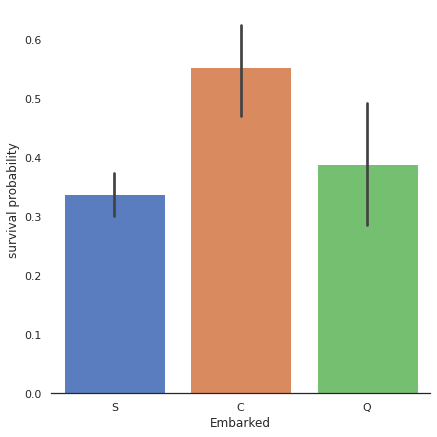

In [94]:
g = sns.factorplot(x="Embarked",y="Survived",data=train,size=6,kind="bar",palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


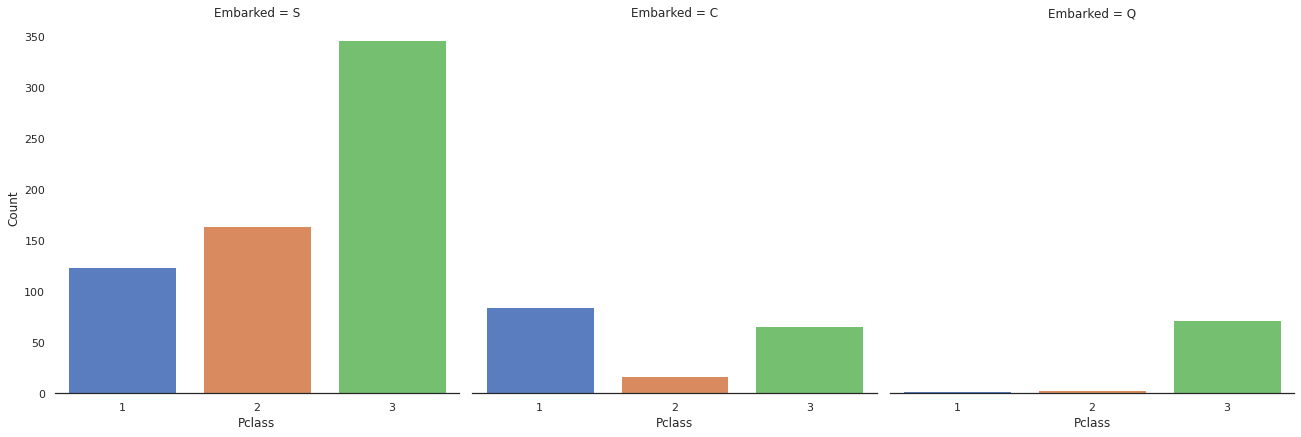

In [95]:
# My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown (Q), Southampton (S).

# Pclass vs Embarked
g = sns.factorplot("Pclass",col="Embarked", data=train, size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt

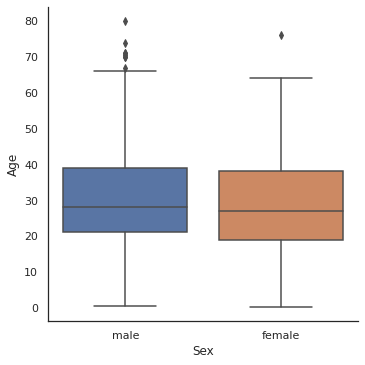

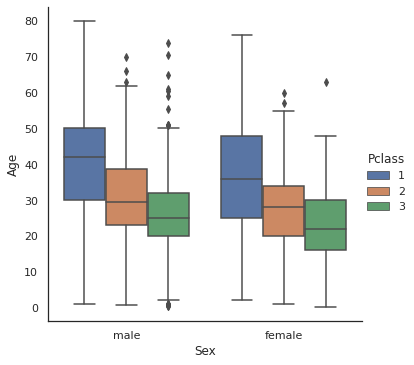

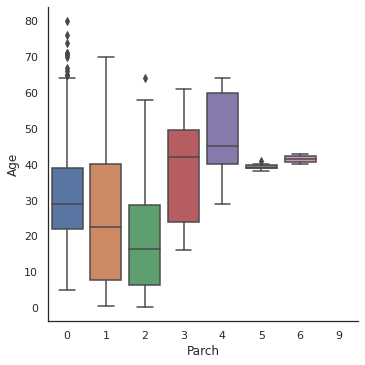

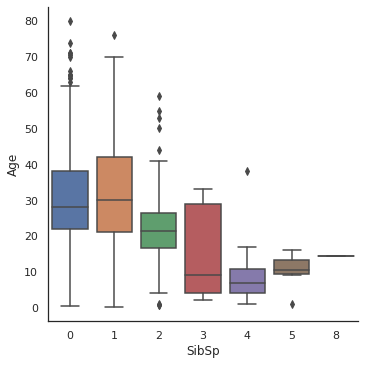

In [96]:
# Filling Missing values

# Age
# looked at the most correlated features with Age
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset, kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset, kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset, kind="box")

Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.

However, 1rst class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.

In [97]:
# convert Sex 0 or 1
dataset["Sex"]=dataset["Sex"].map({"male":0, "female":1})

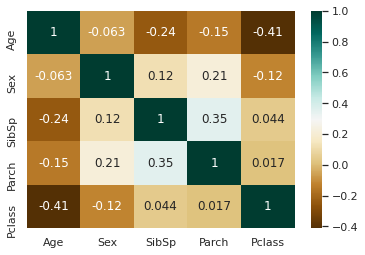

In [98]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(), cmap="BrBG", annot=True)

The correlation map confirms the factorplots observations except for Parch. Age is not correlated with Sex, but is negatively correlated with Pclass, Parch and SibSp.

In the plot of Age in function of Parch, Age is growing with the number of parents / children. But the general correlation is negative.

So, i decided to use SibSP, Parch and Pclass in order to impute the missing ages.

The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp.

In [99]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)
for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][( (dataset["Parch"]==dataset.iloc[i]["Parch"]) \
                               & (dataset["SibSp"]==dataset.iloc[i]["SibSp"]) \
                               & (dataset["Pclass"]==dataset.iloc[i]["Pclass"]) )].median()
    if not np.isnan(age_pred):
        dataset["Age"].iloc[i] = age_pred
    else :
        dataset["Age"].iloc[i] = age_med

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


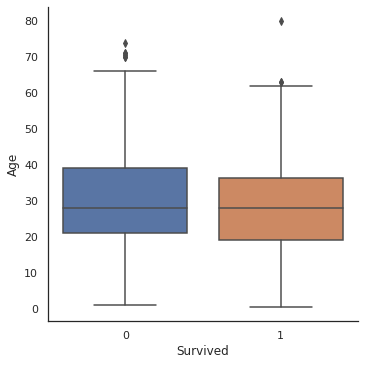

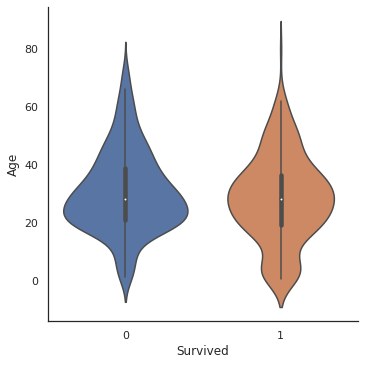

In [100]:
g = sns.factorplot(x="Survived", y="Age", data=train, kind="box")
g = sns.factorplot(x="Survived", y="Age", data=train, kind="violin")

In [101]:
# Name/Title
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
#dataset["Title"].head()
dataset["Title"].value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Dr                8
Rev               8
Col               4
Mlle              2
Major             2
Ms                2
Capt              1
the Countess      1
Don               1
Jonkheer          1
Lady              1
Dona              1
Mme               1
Sir               1
Name: Title, dtype: int64

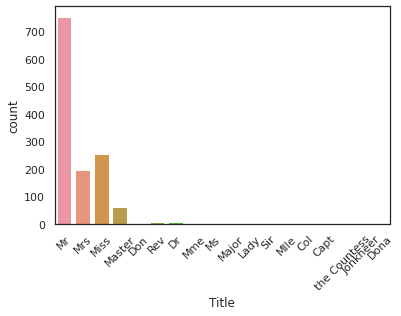

In [102]:
g = sns.countplot(x="Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [103]:
# Group titles in 4 categories
dataset["Title"] = dataset["Title"].replace(["Lady","the Countess", "Countess", "Capt","Col", 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

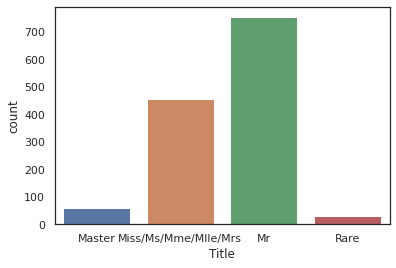

In [104]:
g = sns.countplot(x="Title", data=dataset)
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


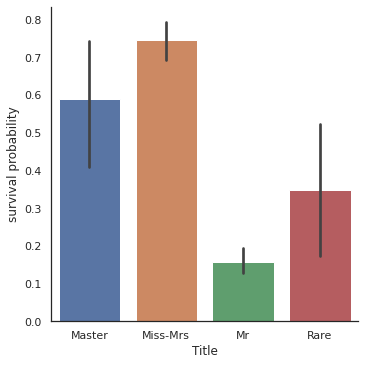

In [105]:
g = sns.factorplot(x="Title", y="Survived", data=dataset, kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

In [106]:
dataset.drop(labels=["Name"], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


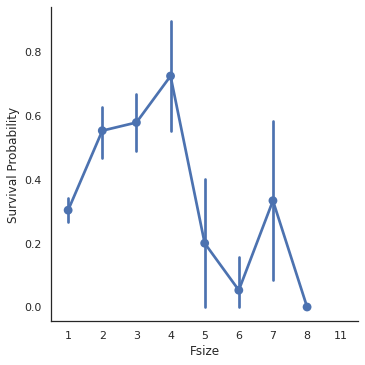

In [107]:
# Family Size
# Fize = SibSp + Parch + 1(the passenger)
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1
g = sns.factorplot(x="Fsize", y="Survived", data=dataset)
g = g.set_ylabels("Survival Probability")

In [108]:
dataset["Single"] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset["SmallF"] = dataset["Fsize"].map(lambda s: 1 if s == 2 else 0)
dataset["MedF" ] = dataset["Fsize"].map(lambda s: 1 if 3<=s<=4 else 0)
dataset["LargeF"] = dataset["Fsize"].map(lambda s: 1 if s>=5 else 0)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt

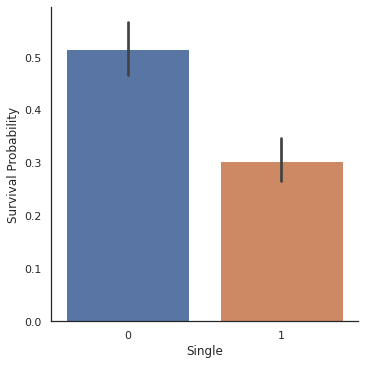

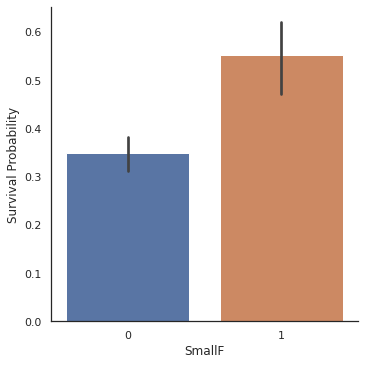

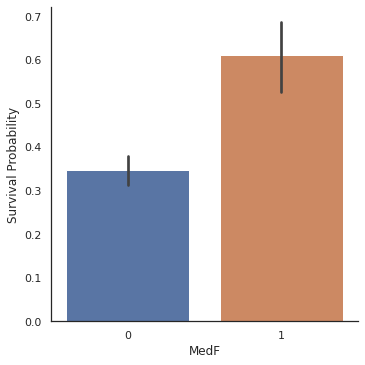

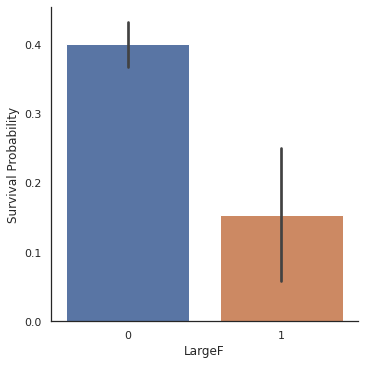

In [109]:
g = sns.factorplot(x="Single",y="Survived",data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF" ,y="Survived",data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

In [110]:
dataset = pd.get_dummies(dataset,columns=["Title"])
dataset = pd.get_dummies(dataset,columns=["Embarked"], prefix="Em")

In [111]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


In [112]:
# cabin
dataset["Cabin"].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [113]:
dataset["Cabin"].isnull().sum()

1007

In [114]:
# replace cabin number by the type of  cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


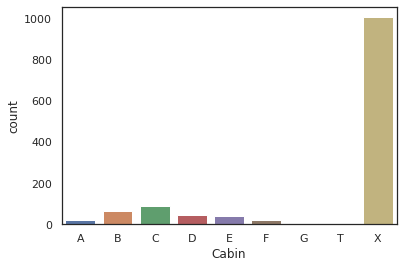

In [115]:
g = sns.countplot(dataset["Cabin"], order=['A','B','C','D','E','F','G','T','X'])

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


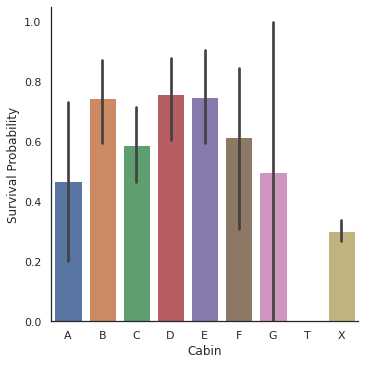

In [116]:
g = sns.factorplot(y="Survived", x="Cabin", data=dataset, kind="bar", order = ['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

Because of the low number of passenger that have a cabin, survival probabilities have an important standard deviation and we can't distinguish between survival probability of passengers in the different desks.

But we can see that passengers with a cabin have generally more chance to survive than passengers without (X).

It is particularly true for cabin B, C, D, E and F.

In [117]:
dataset = pd.get_dummies(dataset, columns=["Cabin"], prefix="Cabin")

In [118]:
# Ticket
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

It could mean that tickets sharing the same prefixes could be booked for cabins placed together. It could therefore lead to the actual placement of the cabins within the ship.

Tickets with same prefixes may have a similar class and survival.

So i decided to replace the Ticket feature column by the ticket prefixe. Which may be more informative.

In [119]:
## Extracting the ticket prefix, whene there is no ? return X
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")
dataset["Ticket"] = pd.Series(Ticket)
dataset["Ticket"].head(10)

0        A5
1        PC
2    STONO2
3         X
4         X
5         X
6         X
7         X
8         X
9         X
Name: Ticket, dtype: object

In [120]:
dataset = pd.get_dummies(dataset, columns=["Ticket"], prefix="T")

In [121]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns=["Pclass"], prefix="Pc")

In [122]:
dataset.drop(labels=["PassengerId"],axis=1, inplace=True)

In [123]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [124]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 67 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   881 non-null    float64
 1   Sex        1299 non-null   int64  
 2   Age        1299 non-null   float64
 3   SibSp      1299 non-null   int64  
 4   Parch      1299 non-null   int64  
 5   Fare       1299 non-null   float64
 6   Fsize      1299 non-null   int64  
 7   Single     1299 non-null   int64  
 8   SmallF     1299 non-null   int64  
 9   MedF       1299 non-null   int64  
 10  LargeF     1299 non-null   int64  
 11  Title_0    1299 non-null   uint8  
 12  Title_1    1299 non-null   uint8  
 13  Title_2    1299 non-null   uint8  
 14  Title_3    1299 non-null   uint8  
 15  Em_C       1299 non-null   uint8  
 16  Em_Q       1299 non-null   uint8  
 17  Em_S       1299 non-null   uint8  
 18  Cabin_A    1299 non-null   uint8  
 19  Cabin_B    1299 non-null   uint8  
 20  Cabin_C 

In [125]:
## Modeling
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [126]:
# Separate train features and label
train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]
X_train = train.drop(labels=["Survived"],axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 6.1 Simple modeling
### 6.1.1 Cross validate models

I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis

In [127]:
# cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


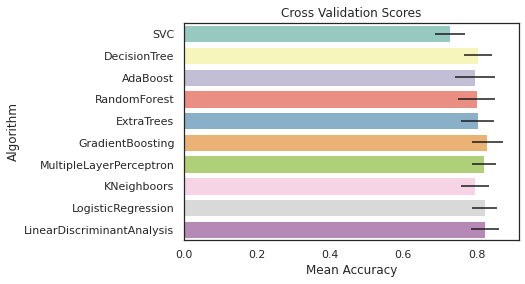

In [128]:
# Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring="accuracy", cv=kfold, n_jobs=4 ))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res, palette="Set3", orient="h", **{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title('Cross Validation Scores')

I decided to choose the SVC, AdaBoost, RandomForest , ExtraTrees and the GradientBoosting classifiers for the ensemble modeling.


##### 6.1.2 Hyperparameter tunning for best models
I performed a grid search optimization for AdaBoost, ExtraTrees , RandomForest, GradientBoosting and SVC classifiers.

I set the "n_jobs" parameter to 4 since i have 4 cpu . The computation time is clearly reduced.

But be carefull, this step can take a long time, i took me 15 min in total on 4 cpu.

In [129]:
## META modeling with ADABoost, RF, ExtraTree, GRBoosting

# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini","entropy"],
                  "base_estimator__splitter"  : ["best","random"],
                  "algorithm" : ["SAMME","SAMME.R"],
                  "n_estimators" : [1,2],
                  "learning_rate" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]
                 }

gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)
gsadaDTC.fit(X_train,Y_train)
ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [130]:
gsadaDTC.best_score_

0.8241317671092953

In [132]:
# ExtraTrees
ExtC = ExtraTreesClassifier()

## search grid for optimal params
ex_param_grid = {
    
    "max_depth" : [None],
    "max_features" : [1,3,10],
    "min_samples_split" : [2,3,10],
    "min_samples_leaf" : [1,3,10],
    "bootstrap" : [False],
    "n_estimators" : [100,300],
    "criterion" : ["gini"]
    
}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv= kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best Score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8342951991828397

In [134]:
# RF Params tunning
RFC = RandomForestClassifier()

## search grid for optimal params
rf_param_grid = {
    
    "max_depth" : [None],
    "max_features" : [1,3,10],
    "min_samples_split" : [2,3,10],
    "min_samples_leaf" : [1,3,10],
    "bootstrap" : [False],
    "n_estimators" : [100,300],
    "criterion" : ["gini"]
    
}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8308605720122575

In [135]:
# Gradient Boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {
    
    'loss' : ["deviance"],
    'n_estimators' : [100,200,300],
    'learning_rate' : [0.1,0.05,0.01],
    'max_depth' : [4,8],
    'min_samples_leaf' : [100,150],
    'max_features' : [0.3,0.1]
    
}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)
gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8308733401430031

In [137]:
# SVC Classifier
SVMC = SVC(probability=True)
svc_param_grid = {
    
    'kernel' : ['rbf'],
    'gamma' : [0.001, 0.01, 0.1, 1],
    'C' : [1,10,50,100,200,300,1000]
     
}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)
gsSVMC.fit(X_train,Y_train)
SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

#### 6.1.3 Plot learning curves

Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

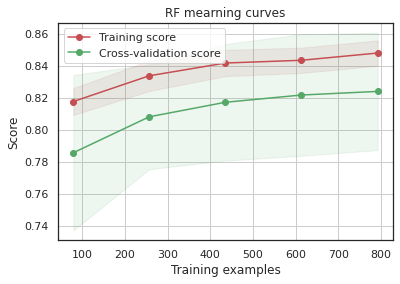

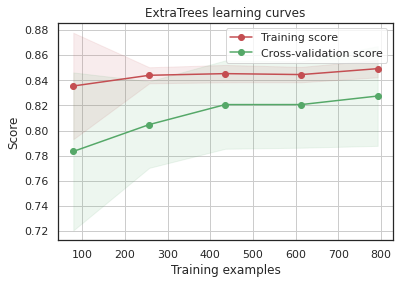

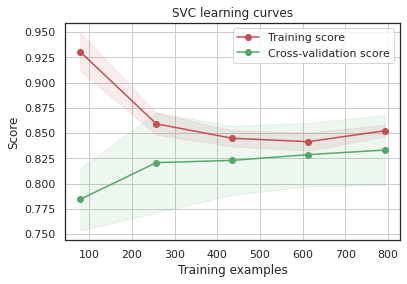

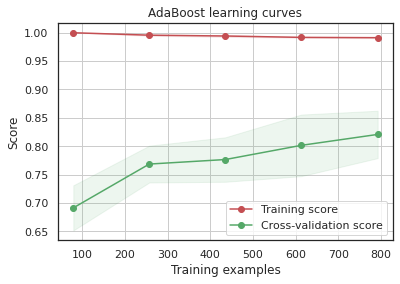

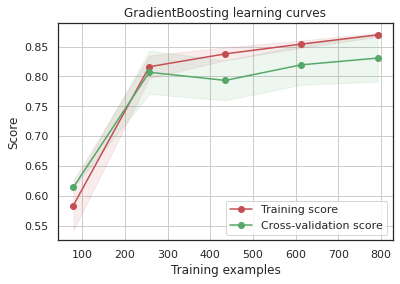

In [139]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                       n_jobs=-1, train_sizes=np.linspace(.1,1.0,5)
                       ):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes = train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std,alpha=0.1,color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_, "RF mearning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, "ExtraTrees learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, "SVC learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, "AdaBoost learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, "GradientBoosting learning curves", X_train, Y_train, cv=kfold)

GradientBoosting and Adaboost classifiers tend to overfit the training set. According to the growing cross-validation curves GradientBoosting and Adaboost could perform better with more training examples.

SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.

#### 6.1.4 Feature importance of tree based classifiers
In order to see the most informative features for the prediction of passengers survival, i displayed the feature importance for the 4 tree based classifiers.

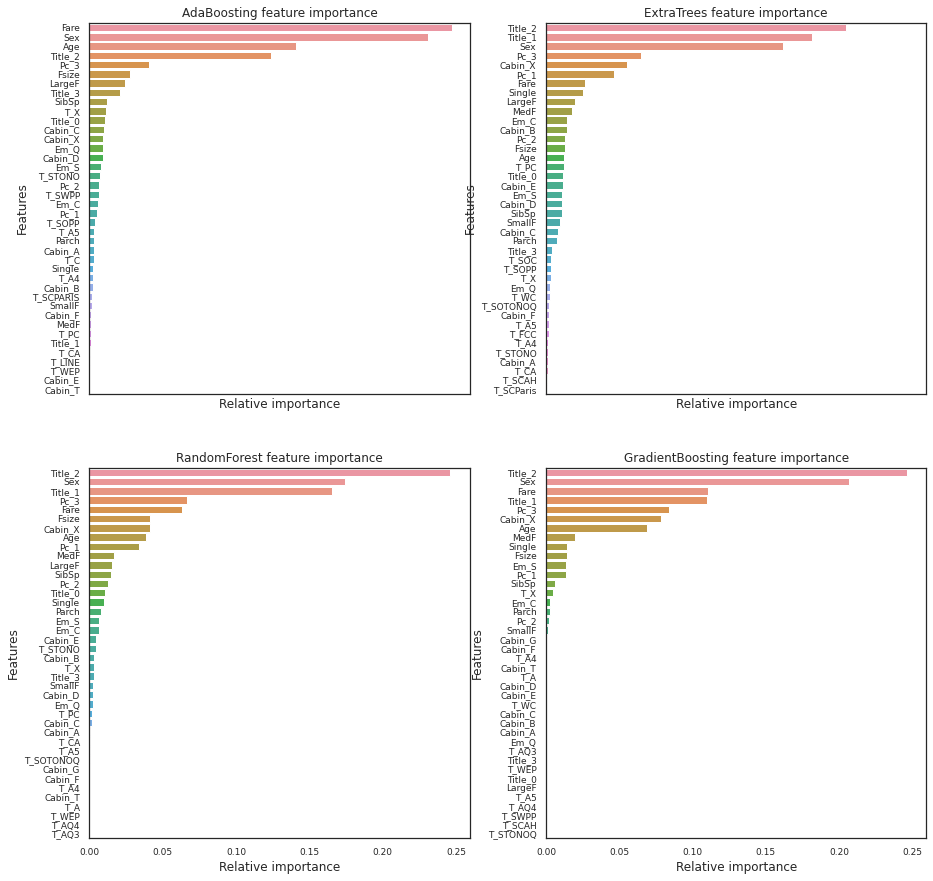

In [142]:
nrows = ncols = 2
fig , axes = plt.subplots(nrows=nrows, ncols=ncols, sharex ="all", figsize=(15,15))
names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x=classifier.feature_importances_[indices][:40], orient='h', ax=axes[row][col])
        g.set_xlabel("Relative importance", fontsize=12)
        g.set_ylabel("Features", fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name+" feature importance")
        nclassifier += 1
    

I plot the feature importance for the 4 tree based classifiers (Adaboost, ExtraTrees, RandomForest and GradientBoosting).

We note that the four classifiers have different top features according to the relative importance. It means that their predictions are not based on the same features. Nevertheless, they share some common important features for the classification , for example 'Fare', 'Title_2', 'Age' and 'Sex'.

Title_2 which indicates the Mrs/Mlle/Mme/Miss/Ms category is highly correlated with Sex.

We can say that:

Pc_1, Pc_2, Pc_3 and Fare refer to the general social standing of passengers.

Sex and Title_2 (Mrs/Mlle/Mme/Miss/Ms) and Title_3 (Mr) refer to the gender.

Age and Title_1 (Master) refer to the age of passengers.

Fsize, LargeF, MedF, Single refer to the size of the passenger family.

##### According to the feature importance of this 4 classifiers, the prediction of the survival seems to be more associated with the Age, the Sex, the family size and the social standing of the passengers more than the location in the boat.

In [143]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")
print(test_Survived_RFC)

0      0
1      0
2      0
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    1
Name: RFC, Length: 418, dtype: int64


   RFC  ExtC  Ada  GBC  SVC
0    0     0    0    0    0
1    0     1    0    0    1
2    0     0    0    0    0
3    0     0    1    0    0
4    1     1    0    0    1


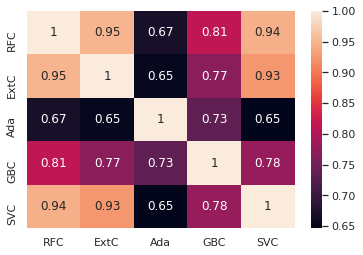

In [145]:
## Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC], axis=1)
print(ensemble_results.head())
g = sns.heatmap(ensemble_results.corr(),annot=True)

The prediction seems to be quite similar for the 5 classifiers except when Adaboost is compared to the others classifiers.

The 5 classifiers give more or less the same prediction but there is some differences. Theses differences between the 5 classifier predictions are sufficient to consider an ensembling vote.



#### 6.2 Ensemble modeling

##### 6.2.1 Combining models
a voting classifier to combine the predictions coming from the 5 classifiers.

the argument 'soft' to the voting parameter to take into account the probability of each vote

In [146]:
votingC = VotingClassifier(estimators=[('rfc',RFC_best),('extc',ExtC_best),('svc',SVMC_best),('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)
votingC = votingC.fit(X_train, Y_train)

In [148]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")
results = pd.concat([IDtest, test_Survived], axis=1)
results.to_csv("ensemble_python_voting.csv", index=False)